In [1]:
cd Desktop/lambda_projects/food_desert/CAMS_ZIP

/home/jm/Desktop/lambda_projects/food_desert/CAMS_ZIP


In [ ]:
'''
Dependencies:

- geopandas
- descartes
- geopy
- numba

'''

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon

In [ ]:
'''
Data files used in this notebook:

CAMS_ZIPCODE_STREET_SPECIFIC.cpg  
CAMS_ZIPCODE_STREET_SPECIFIC.shp
CAMS_ZIPCODE_STREET_SPECIFIC.dbf  
CAMS_ZIPCODE_STREET_SPECIFIC.shp.xml
CAMS_ZIPCODE_STREET_SPECIFIC.prj  
CAMS_ZIPCODE_STREET_SPECIFIC.shx
CAMS_ZIPCODE_STREET_SPECIFIC.sbn
CAMS_ZIPCODE_STREET_SPECIFIC.sbx
Listing_of_Active_Businesses.csv

'''

In [118]:
# Loading the data files
polygon_file = 'CAMS_ZIPCODE_STREET_SPECIFIC.shp'
polygons = gpd.read_file(polygon_file)
polygons = polygons.to_crs(epsg=4326)

In [119]:
polygons.head(2)

,OBJECTID_1,OBJECTID,FID_1,Name,SDE_STATE_,ORIG_FID,Distance,Zip_Num,Shape_area,Shape_len,geometry
0,1,105,0,90001,0.0,8499,0.0,90001,9.562251e+07,55969.055693,POLYGON ((-118.2562720327559 33.98921307224975...
1,2,194,1,90004,0.0,8502,0.0,90004,8.419310e+07,61463.722654,POLYGON ((-118.2904153141149 34.08336856317362...


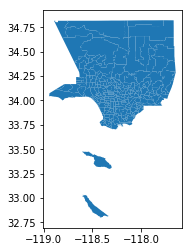

In [120]:
gdf = GeoDataFrame(polygons)
gdf.plot()

In [67]:
poly1 = polygons.iloc[0].geometry
poly1.bounds

(-118.26518357797723, 33.95953496947096, -118.22953799058895, 33.9893361024826)

In [78]:
poly1_points = gen_points_inside_polygon(poly1, miles=1)
poly1_points

In [79]:
poly1_points[0].xy

(array('d', [-118.25518357797722]), array('d', [33.96678496947096]))

In [80]:
poly1_points[1].xy

(array('d', [-118.25518357797722]), array('d', [33.981284969470956]))

In [71]:
#new df w/ only the columns we need:
zip_df = polygons[['Zip_Num', 'geometry']].rename(columns={'Zip_Num':'zip_code'})

In [72]:
zip_df.head(2)

,zip_code,geometry
0,90001,POLYGON ((-118.2562720327559 33.98921307224975...
1,90004,POLYGON ((-118.2904153141149 34.08336856317362...


In [121]:
def gen_points_inside_polygon(polygon, miles=1):
    '''Takes a polygon and number of miles as input, creates a square grid around the polygon edges
    and iterates in default one mile chunks exhaustively acorss the grid, returns list of all the points
    generated'''
    
    #convert miles to degrees latitude/longitude 
    lat_increment = miles * 0.0145
    lon_increment = miles * 0.02 #this is specifically for L.A. (varies based on lat)
    
    #get the four corners of a grid of max and min lat/long values 
    min_long, min_lat, max_long, max_lat = polygon.bounds
    
    #iterate over the grid one unit at a time, append lats and lons to lists:
    longs, lats = [], []
    
    #Latitudes: start one half unit away from min_lat:
    lat = min_lat + (lat_increment / 2)
    while lat < max_lat:
        lats.append(lat)
        lat += lat_increment
    lats.append(max_lat)
    
    #repeat for longitude; conversion is diff, 1 mile = 0.0145 degrees
    #start one half unit above the min_lat
    lon = min_long + (lon_increment / 2)
    while lon < max_long:
        longs.append(lon)
        #increase .02 degrees (longitude conversion for Los Angeles)
        lon += lon_increment
    longs.append(max_long)

    #iterate thru all latitude and longitude points, instantiate shapely Point objects
    #and append them to a list:
    points = []
    for i in range(len(longs)):
        for j in range(len(lats)):
            points.append(Point(longs[i], lats[j]))
            
    #iterate over the points and throw out ones outside the polygon:
    points_inside_polygon = []
    for i in range(len(points)):
        if polygon.contains(points[i]):
            points_inside_polygon.append(points[i])
            
    #return the list of Shapely points which are bound inside the polygon        
    return points_inside_polygon

In [122]:
#call the function and make a new column in our zip_df that holds a lit of points inside the polygon
zip_df['test_points'] = zip_df.geometry.apply(gen_points_inside_polygon)
#create new column that displays the num of points inside the polygon
zip_df['num_points'] = zip_df['test_points'].apply(len)

In [126]:
zip_df.head()

,zip_code,geometry,test_points,num_points
0,90001,POLYGON ((-118.2562720327559 33.98921307224975...,"[POINT (-118.2551835779772 33.96678496947096),...",3
1,90004,POLYGON ((-118.2904153141149 34.08336856317362...,"[POINT (-118.3285740655758 34.0757961312489), ...",3
2,90006,POLYGON ((-118.2843683929007 34.05603885709694...,"[POINT (-118.3004893523277 34.04654480996436),...",2
3,90007,POLYGON ((-118.2924807961456 34.04013885183708...,"[POINT (-118.2908632097603 34.03358223438523),...",2
4,90008,POLYGON ((-118.3673661121153 34.01806773141392...,"[POINT (-118.3679383527987 34.00413954843774),...",3


In [127]:
zip_df.num_points.sum()

3685

In [136]:
#Load the business data and clean up the df to our final list of markets/groceries
df_business = pd.read_csv('Listing_of_Active_Businesses.csv')

# Return a dataframe that contains market, grocery or food.
df_business_market = df_business[df_business['PRIMARY NAICS DESCRIPTION'].str.contains('market|grocery', flags=re.IGNORECASE, regex=True) == True]

# Return a dataframe that doesn't contain 'telephone|business|research'
df_business_market_clean = df_business_market[~df_business_market['PRIMARY NAICS DESCRIPTION'].str.contains('telephone|business|research') == True]

# Extract Latitude and put it in a column
df_business_market_clean['LATITUDE'] = df_business_market_clean['LOCATION'].str.extract('\((.*),').astype(float)

# Extract Longitude and put it in a column
df_business_market_clean['LONGITUDE'] = df_business_market_clean['LOCATION'].str.extract(',(.*)\)').astype(float)

# Remove coordinates outside of LA
df_business_market_clean = df_business_market_clean[(df_business_market_clean['LONGITUDE'] < -117.7) & (df_business_market_clean['LONGITUDE'] > -118.9)]

# Dataframe with no Nulls for location
markets = df_business_market_clean.dropna(subset=['LOCATION'])

#drop columns we wont be needing:
drop_cols = ['LOCATION ACCOUNT #', 'BUSINESS NAME', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
             'MAILING CITY', 'MAILING ZIP CODE', 'NAICS', 'COUNCIL DISTRICT', 'LOCATION START DATE',
             'LOCATION END DATE']

markets = markets.drop(columns=drop_cols).reset_index(drop=True)

#convert Location col to Shapely Point:
for i in range(len(markets)):
    lat = markets.at[i, 'LATITUDE']
    lon = markets.at[i, 'LONGITUDE']
    markets.at[i, "LOCATION"] = Point(lon, lat)

/home/jm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [135]:
markets.head()

,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,PRIMARY NAICS DESCRIPTION,LOCATION,LATITUDE,LONGITUDE
0,SILVER MOON MARKET,2501 E 4TH STREET,LOS ANGELES,90033-4418,Grocery & related products,POINT (-118.2106 34.0401),34.0401,-118.2106
1,VENUS MARKET,10117 AVALON BLVD,LOS ANGELES,90003-4817,Grocery stores (including supermarkets & conve...,POINT (-118.2651 33.9442),33.9442,-118.2651
2,MEADOW MALD MARKET,5393 ALHAMBRA AVENUE,LOS ANGELES,90032-3411,Grocery stores (including supermarkets & conve...,POINT (-118.1683 34.0769),34.0769,-118.1683
3,NaN,746 MARKET COURT SPACE #10-11,LOS ANGELES,90021-1103,Fruit & vegetable markets,POINT (-118.2416 34.0347),34.0347,-118.2416
4,7 ELEVEN 2136-33028A | 7-ELEVEN STORE 33028A,2200 W SUNSET BLVD,LOS ANGELES,90026-3002,Grocery stores (including supermarkets & conve...,POINT (-118.266 34.0778),34.0778,-118.2660


In [151]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def travel(lon, lat, bearing=0, miles=0.5):
    import geopy
    import geopy.distance
    
    # Starting point
    start = geopy.Point(latitude=lat, longitude=lon)

    # Initialized with a default distance of 0.5 mi.
    end = geopy.distance.geodesic(miles=miles)

    # Destination method which takes the starting point and bearings(North=0).
    # Return coordinates from start to distance,d, traveled
    return end.destination(point=start, bearing=bearing)
       
def make_circle(lon, lat, miles=1):
    '''takes a coordinate of latitude, longitude and a distance in miles, creates a 360 sided polygon around the point'''
    circle_points = []  
    for i in range(360):
        new_point = travel(lon, lat, bearing=i, miles=miles)
        new_point = new_point[1], new_point[0]
        circle_points.append(new_point)
    circle = Polygon(circle_points)
    return circle

def get_groceries_within_circle(df, circle):
    df_copy = df.copy()
    in_circle = []
    #iterate over every grocery in the df
    for i in range(len(df_copy)):
        point = df_copy.iloc[i]['LOCATION']
        if circle.contains(point):
            # Grocery within Circle
            in_circle.append(True)
        else:
            # NoGrocery within Circle
            in_circle.append(False)
    df_copy['in_circle'] = in_circle
    # Returns a data frame containing all grocery stores within the circle
    return df_copy[df_copy['in_circle'] == True]

def search_for_deserts(list_of_points):
    '''takes a list of Shapely Points, iterates over them and checks if grocery is nearby, 
    return False if groceries are nearby, True if food desert'''
    flag = False
    desert_list = []
    for point in list_of_points:
        lon, lat = point.x, point.y
        circle = make_circle(lon, lat)
        result_df = get_groceries_within_circle(markets, circle)
        if len(result_df) == 0:
            desert_list.append((lon, lat))
            flag = True
    if flag:
        return desert_list
    else:
        return flag

In [144]:
subset = zip_df.iloc[:2]
subset

,zip_code,geometry,test_points,num_points
0,90001,POLYGON ((-118.2562720327559 33.98921307224975...,"[POINT (-118.2551835779772 33.96678496947096),...",3
1,90004,POLYGON ((-118.2904153141149 34.08336856317362...,"[POINT (-118.3285740655758 34.0757961312489), ...",3


In [146]:
subset['desert_search'] = subset.test_points.apply(search_for_deserts)
subset

/home/jm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,zip_code,geometry,test_points,num_points,desert_search
0,90001,POLYGON ((-118.2562720327559 33.98921307224975...,"[POINT (-118.2551835779772 33.96678496947096),...",3,False
1,90004,POLYGON ((-118.2904153141149 34.08336856317362...,"[POINT (-118.3285740655758 34.0757961312489), ...",3,False


In [190]:
len(zip_df)

358

In [147]:
first50 = zip_df.iloc[:50]
second50 = zip_df.iloc[50:100]
third50 = zip_df.iloc[100:150]
fourth50 =zip_df.iloc[150:200]
fifth50 = zip_df.iloc[200:250]
sixth50 = zip_df.iloc[250:300]
last58 = zip_df.iloc[300:]

In [152]:
%%time
first50['desert_search'] = first50.test_points.apply(search_for_deserts)


CPU times: user 2min 28s, sys: 76.2 ms, total: 2min 28s
Wall time: 2min 28s


/home/jm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [154]:
first50

,zip_code,geometry,test_points,num_points,desert_search
0,90001,POLYGON ((-118.2562720327559 33.98921307224975...,"[POINT (-118.2551835779772 33.96678496947096),...",3,False
1,90004,POLYGON ((-118.2904153141149 34.08336856317362...,"[POINT (-118.3285740655758 34.0757961312489), ...",3,False
2,90006,POLYGON ((-118.2843683929007 34.05603885709694...,"[POINT (-118.3004893523277 34.04654480996436),...",2,False
3,90007,POLYGON ((-118.2924807961456 34.04013885183708...,"[POINT (-118.2908632097603 34.03358223438523),...",2,False
4,90008,POLYGON ((-118.3673661121153 34.01806773141392...,"[POINT (-118.3679383527987 34.00413954843774),...",3,"[(-118.36793835279867, 34.00413954843774)]"
5,90010,POLYGON ((-118.3200851846698 34.06195296554272...,[],0,False
6,90011,POLYGON ((-118.2434683015289 34.00246828287713...,"[POINT (-118.2640418969102 33.99446982835475),...",5,False
7,90012,POLYGON ((-118.2416423927089 34.09261140746374...,"[POINT (-118.246994264942 34.0632756383682), P...",3,False
8,90013,POLYGON ((-118.2505815697205 34.05274961173777...,[POINT (-118.2448006971619 34.0454120620006)],1,False
9,90014,POLYGON ((-118.2546521370389 34.04860724411184...,[POINT (-118.2486603729884 34.04436696954181)],1,False


In [153]:
%%time
second50['desert_search'] = second50.test_points.apply(search_for_deserts)
second50

CPU times: user 4min 25s, sys: 160 ms, total: 4min 25s
Wall time: 4min 25s


/home/jm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
%%time
third50['desert_search'] = third50.test_points.apply(search_for_deserts)
third50

In [ ]:
fourth50['desert_search'] = fourth50.test_points.apply(search_for_deserts)
fourth50

In [ ]:
fifth50['desert_search'] = fifth50.test_points.apply(search_for_deserts)
fifth50

In [ ]:
sixth50['desert_search'] = sixth50.test_points.apply(search_for_deserts)
sixth50

In [ ]:
last58['desert_search'] = last58.test_points.apply(search_for_deserts)
last58

In [163]:
deserts2 = second50[second50['desert_search'] != False]

In [173]:
deserts = deserts2.desert_search.apply(pd.Series).stack().values

In [175]:
desert_points = []
for desert in deserts:
    desert_points.append(Point(desert[0], desert[1]))

In [181]:
gdf = GeoDataFrame(desert_points).rename(columns={0:'geometry'})
gdf.head()

,geometry
0,POINT (-118.3899892647996 33.99883417848204)
1,POINT (-118.1345447732026 33.95709488568854)
2,POINT (-118.1521595994302 33.93881990690949)
3,POINT (-118.1521595994302 33.95331990690948)
4,POINT (-118.1321595994302 33.93881990690949)


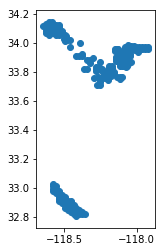

In [182]:
gdf.plot()